## Section 1. Introduction ##

In this notebook, the dataset to be processed is the Labor Force Survey conducted April 2016 and retrieved through Philippine Statistics Authority database. 



In [15]:
import random
import numpy as np
import pickle
import os
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

# autoreload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Importing LFS PUF April 2016.CSV</h1>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

try:
    lfs_data = pd.read_csv("LFS PUF April 2016.CSV")
except FileNotFoundError:
    print("Error: CSV file not found. Please make sure the file exists in the correct directory or provide the correct path.")
    exit()


<h1>Data Information</h1>

It is good practice to first obtain the <pre>info()</pre> of the dataset, in order to have a good preview of what to expect.

In [4]:
lfs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180862 entries, 0 to 180861
Data columns (total 50 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PUFREG           180862 non-null  int64  
 1   PUFPRV           180862 non-null  int64  
 2   PUFPRRCD         180862 non-null  int64  
 3   PUFHHNUM         180862 non-null  int64  
 4   PUFURB2K10       180862 non-null  int64  
 5   PUFPWGTFIN       180862 non-null  float64
 6   PUFSVYMO         180862 non-null  int64  
 7   PUFSVYYR         180862 non-null  int64  
 8   PUFPSU           180862 non-null  int64  
 9   PUFRPL           180862 non-null  int64  
 10  PUFHHSIZE        180862 non-null  int64  
 11  PUFC01_LNO       180862 non-null  int64  
 12  PUFC03_REL       180862 non-null  int64  
 13  PUFC04_SEX       180862 non-null  int64  
 14  PUFC05_AGE       180862 non-null  int64  
 15  PUFC06_MSTAT     180862 non-null  object 
 16  PUFC07_GRADE     180862 non-null  obje

As we can see, there are 50 total variables/features in the dataset; of which, 
<ul><li>1 contains float values, </li>
<li>14 contain integer values, and </li>
<li><b>35 are object values</b>.</li></ul>
<br>
We can then infer that we must first <b>clean the 35 columns</b> that have object values before even doing any processing.

Just for further inspection, we have applied a <b>lambda function</b> onto each of the variables in the dataset. We have done this in order not to do the tedious work of using .unique() for every specified column, and instead applied it to all within LFS_Data. 

We can now <b>see all the unique values</b> present within <b>each variable/feature</b> within the dataset.

We can see that for "PUFC04_SEX" or the Sex of the surveyed, there are only 2 unique entries;
for "PUFREG" or the PH Region from where the survey was answered from, there are 17 unique entries;
and for "PUFHHNUM" or the unique sequential number of the surveyed household, there are 40880 unique entries; etc.

In [5]:
lfs_data.apply(lambda x: x.nunique())

PUFREG                17
PUFPRV                86
PUFPRRCD             116
PUFHHNUM           40880
PUFURB2K10             2
PUFPWGTFIN         35599
PUFSVYMO               1
PUFSVYYR               1
PUFPSU               975
PUFRPL                 4
PUFHHSIZE             20
PUFC01_LNO            23
PUFC03_REL            11
PUFC04_SEX             2
PUFC05_AGE           100
PUFC06_MSTAT           7
PUFC07_GRADE          68
PUFC08_CURSCH          3
PUFC09_GRADTECH        3
PUFC10_CONWR           6
PUFC11_WORK            3
PUFC12_JOB             3
PUFC14_PROCC          44
PUFC16_PKB            88
PUFC17_NATEM           4
PUFC18_PNWHRS         17
PUFC19_PHOURS        103
PUFC20_PWMORE          3
PUFC21_PLADDW          3
PUFC22_PFWRK           3
PUFC23_PCLASS          8
PUFC24_PBASIS          9
PUFC25_PBASIC       1152
PUFC26_OJOB            3
PUFC27_NJOBS           6
PUFC28_THOURS        111
PUFC29_WWM48H          6
PUFC30_LOOKW           3
PUFC31_FLWRK           3
PUFC32_JOBSM           7


IDK MIGHT BE UNNECESSARY TO SHOW, HELP

-andrei

In [6]:
lfs_data.describe()

,PUFREG,PUFPRV,PUFPRRCD,PUFHHNUM,PUFURB2K10,PUFPWGTFIN,PUFSVYMO,PUFSVYYR,PUFPSU,PUFRPL,PUFHHSIZE,PUFC01_LNO,PUFC03_REL,PUFC04_SEX,PUFC05_AGE
count,180862.000000,180862.000000,180862.000000,180862.000000,180862.000000,180862.000000,180862.0,180862.0,180862.000000,180862.000000,180862.000000,180862.000000,180862.000000,180862.000000,180862.000000
mean,9.398801,45.825309,4585.055324,20528.231873,1.574947,568.527169,4.0,2016.0,386.270272,2.490379,5.504783,3.252391,2.931489,1.493874,27.889772
std,4.667034,24.939767,2494.028733,11827.708144,0.494352,508.519331,0.0,0.0,440.160045,1.118970,2.370169,2.077130,1.832299,0.499964,20.052132
min,1.000000,1.000000,100.000000,1.000000,1.000000,34.998400,4.0,2016.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,5.000000,24.000000,2402.000000,10256.250000,1.000000,245.065975,4.0,2016.0,107.000000,1.000000,4.000000,2.000000,2.000000,1.000000,11.000000
50%,10.000000,46.000000,4600.000000,20406.000000,2.000000,392.993500,4.0,2016.0,243.000000,2.000000,5.000000,3.000000,3.000000,1.000000,24.000000
75%,13.000000,71.000000,7100.000000,30962.000000,2.000000,679.526775,4.0,2016.0,482.000000,3.000000,7.000000,4.000000,3.000000,2.000000,42.000000
max,17.000000,98.000000,9804.000000,40880.000000,2.000000,4509.316000,4.0,2016.0,3053.000000,4.000000,23.000000,23.000000,11.000000,2.000000,99.000000


It is good practice to check the dataset for duplicate entries.

In [7]:
lfs_data.duplicated().sum()

np.int64(0)

Seeing as there are no duplicate entries, this is good news for this dataset!

Before we proceed to processing the data from this dataset, we first want to process all the Object datatypes in the 35 columns.

It is also good practice to check if the Object datatype is caused by incorrect entries for the null value. 

We can check this by using the functions isnull() in tandem with any() in order to find all null values in each of the features.

In [8]:
lfs_data.isnull().any()

PUFREG             False
PUFPRV             False
PUFPRRCD           False
PUFHHNUM           False
PUFURB2K10         False
PUFPWGTFIN         False
PUFSVYMO           False
PUFSVYYR           False
PUFPSU             False
PUFRPL             False
PUFHHSIZE          False
PUFC01_LNO         False
PUFC03_REL         False
PUFC04_SEX         False
PUFC05_AGE         False
PUFC06_MSTAT       False
PUFC07_GRADE       False
PUFC08_CURSCH      False
PUFC09_GRADTECH    False
PUFC10_CONWR       False
PUFC11_WORK        False
PUFC12_JOB         False
PUFC14_PROCC       False
PUFC16_PKB         False
PUFC17_NATEM       False
PUFC18_PNWHRS      False
PUFC19_PHOURS      False
PUFC20_PWMORE      False
PUFC21_PLADDW      False
PUFC22_PFWRK       False
PUFC23_PCLASS      False
PUFC24_PBASIS      False
PUFC25_PBASIC      False
PUFC26_OJOB        False
PUFC27_NJOBS       False
PUFC28_THOURS      False
PUFC29_WWM48H      False
PUFC30_LOOKW       False
PUFC31_FLWRK       False
PUFC32_JOBSM       False


Seeing how all of the features returned a false value should be a happy sight to see!

However, we must not be overconfident and too complacent.

Upon actual inspection of the dataset through CSV file, we can see that there truly is an error in the returned FALSE values: there exists many empty entries per row.

This means that the dataset does, in fact, have null values; just not in the form the computer recognizes as null. Instead, they are written in different variations of whitespace.

Below actually finds all variations of null and counts how many null/blank instances there truly exists per column.

In [9]:
print("Actual Count of Missing Values")
white_fucking_spaces = [" " , "  " , "   " , "     "]
lfs_data.isin(white_fucking_spaces).sum()

Actual Count of Missing Values


PUFREG                  0
PUFPRV                  0
PUFPRRCD                0
PUFHHNUM                0
PUFURB2K10              0
PUFPWGTFIN              0
PUFSVYMO                0
PUFSVYYR                0
PUFPSU                  0
PUFRPL                  0
PUFHHSIZE               0
PUFC01_LNO              0
PUFC03_REL              0
PUFC04_SEX              0
PUFC05_AGE              0
PUFC06_MSTAT        18339
PUFC07_GRADE        18339
PUFC08_CURSCH      107137
PUFC09_GRADTECH     57782
PUFC10_CONWR        57782
PUFC11_WORK         21894
PUFC12_JOB          93306
PUFC14_PROCC       108360
PUFC16_PKB         108360
PUFC17_NATEM       109507
PUFC18_PNWHRS      109507
PUFC19_PHOURS      109507
PUFC20_PWMORE      109507
PUFC21_PLADDW      109507
PUFC22_PFWRK       109507
PUFC23_PCLASS      109507
PUFC24_PBASIS      138947
PUFC25_PBASIC      144274
PUFC26_OJOB        109507
PUFC27_NJOBS       174924
PUFC28_THOURS      109507
PUFC29_WWM48H      163629
PUFC30_LOOKW       132692
PUFC31_FLWRK

Just for additional information, we can also take the total number of columns with null values.

In [10]:
print("Total Count of Columns with Missing Values")
(lfs_data.isin(white_fucking_spaces).sum() > 0).sum()

Total Count of Columns with Missing Values


np.int64(35)

So far, we have the following information:

<ul><li>There are 35 columns that have the Object datatype</li>
<li>Those 35 contain null values, hence incorrectly displaying the datatypes</li>
<li>There exists columns with missing entries; ranging from 10.13% to 99.11% missing data per column</li>
</ul>

In [11]:
lfs_data['PUFC06_MSTAT'].head()

0    2
1    2
2    1
3    2
4    2
Name: PUFC06_MSTAT, dtype: object

In [12]:
white_fucking_spaces = [" " , "  " , "   " , "     "]
lfs_data.isin(white_fucking_spaces).sum()

PUFREG                  0
PUFPRV                  0
PUFPRRCD                0
PUFHHNUM                0
PUFURB2K10              0
PUFPWGTFIN              0
PUFSVYMO                0
PUFSVYYR                0
PUFPSU                  0
PUFRPL                  0
PUFHHSIZE               0
PUFC01_LNO              0
PUFC03_REL              0
PUFC04_SEX              0
PUFC05_AGE              0
PUFC06_MSTAT        18339
PUFC07_GRADE        18339
PUFC08_CURSCH      107137
PUFC09_GRADTECH     57782
PUFC10_CONWR        57782
PUFC11_WORK         21894
PUFC12_JOB          93306
PUFC14_PROCC       108360
PUFC16_PKB         108360
PUFC17_NATEM       109507
PUFC18_PNWHRS      109507
PUFC19_PHOURS      109507
PUFC20_PWMORE      109507
PUFC21_PLADDW      109507
PUFC22_PFWRK       109507
PUFC23_PCLASS      109507
PUFC24_PBASIS      138947
PUFC25_PBASIC      144274
PUFC26_OJOB        109507
PUFC27_NJOBS       174924
PUFC28_THOURS      109507
PUFC29_WWM48H      163629
PUFC30_LOOKW       132692
PUFC31_FLWRK

In [13]:
lfs_data.isnull().sum()

PUFREG             0
PUFPRV             0
PUFPRRCD           0
PUFHHNUM           0
PUFURB2K10         0
PUFPWGTFIN         0
PUFSVYMO           0
PUFSVYYR           0
PUFPSU             0
PUFRPL             0
PUFHHSIZE          0
PUFC01_LNO         0
PUFC03_REL         0
PUFC04_SEX         0
PUFC05_AGE         0
PUFC06_MSTAT       0
PUFC07_GRADE       0
PUFC08_CURSCH      0
PUFC09_GRADTECH    0
PUFC10_CONWR       0
PUFC11_WORK        0
PUFC12_JOB         0
PUFC14_PROCC       0
PUFC16_PKB         0
PUFC17_NATEM       0
PUFC18_PNWHRS      0
PUFC19_PHOURS      0
PUFC20_PWMORE      0
PUFC21_PLADDW      0
PUFC22_PFWRK       0
PUFC23_PCLASS      0
PUFC24_PBASIS      0
PUFC25_PBASIC      0
PUFC26_OJOB        0
PUFC27_NJOBS       0
PUFC28_THOURS      0
PUFC29_WWM48H      0
PUFC30_LOOKW       0
PUFC31_FLWRK       0
PUFC32_JOBSM       0
PUFC33_WEEKS       0
PUFC34_WYNOT       0
PUFC35_LTLOOKW     0
PUFC36_AVAIL       0
PUFC37_WILLING     0
PUFC38_PREVJOB     0
PUFC40_POCC        0
PUFC41_WQTR  

<h1>EDA</h1>

1. How is the labor force distributed across different regions?

C:\Users\andre\AppData\Local\Temp\ipykernel_20972\115261799.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_distribution.index.tolist(), y=region_distribution.values, palette="viridis")


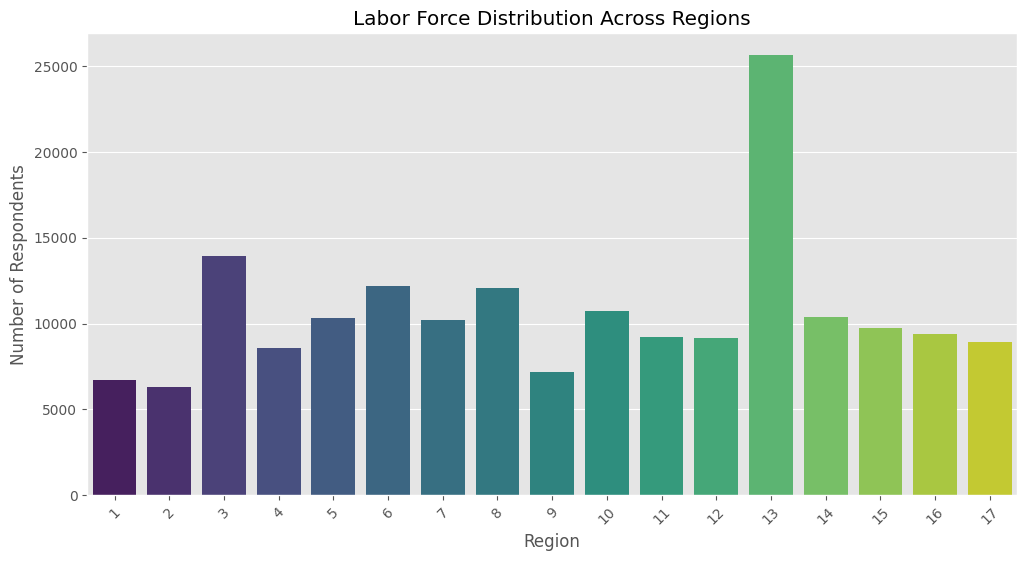

In [20]:
region_distribution = lfs_data["PUFREG"].value_counts().sort_index()
# print(region_distribution)

plt.figure(figsize=(12, 6))
sns.barplot(x=region_distribution.index.tolist(), y=region_distribution.values, palette="viridis")

plt.xlabel("Region")
plt.ylabel("Number of Respondents")
plt.title("Labor Force Distribution Across Regions")
plt.xticks(rotation=45)  # Rotate for better readability
plt.show()

# employment_distribution = lfs_data.groupby("PUFREG")["PUFC11_WORK"].value_counts(normalize=True).unstack()
# print(employment_distribution)

Analysis: 




In [26]:
region_distribution_percentage = (region_distribution / region_distribution.sum()) * 100
region_distribution_percentage

PUFREG
1      3.708352
2      3.494930
3      7.721357
4      4.736761
5      5.704902
6      6.751556
7      5.653482
8      6.685760
9      3.974301
10     5.946523
11     5.091727
12     5.061870
13    14.179872
14     5.744711
15     5.406332
16     5.206732
17     4.930831
Name: count, dtype: float64

2. How is the labor force distributed by employment status?

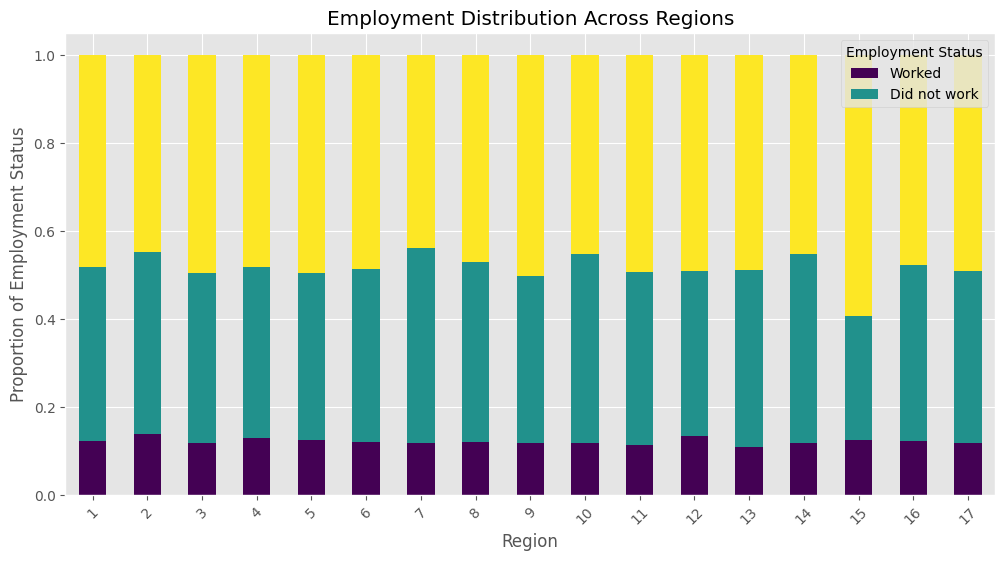

In [31]:
employment_distribution = lfs_data.groupby("PUFREG")["PUFC11_WORK"].value_counts(normalize=True).unstack()

employment_distribution.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")

plt.xlabel("Region")
plt.ylabel("Proportion of Employment Status")
plt.title("Employment Distribution Across Regions")
plt.legend(title="Employment Status", labels=["Worked", "Did not work"])
plt.xticks(rotation=45)
plt.show()



This can better be visualized with a bar graph comparison

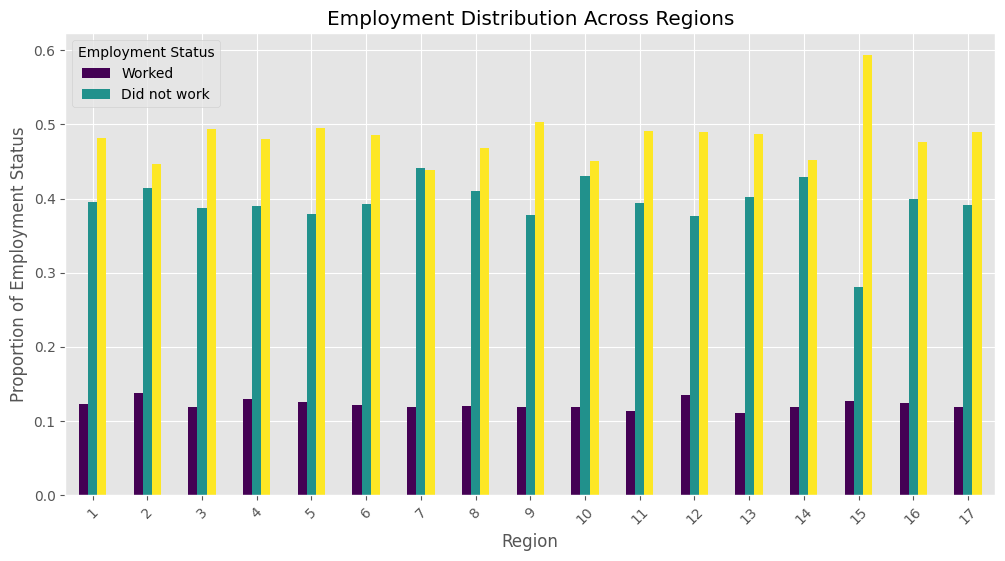

In [32]:
employment_distribution.plot(kind="bar", figsize=(12, 6), colormap="viridis")

plt.xlabel("Region")
plt.ylabel("Proportion of Employment Status")
plt.title("Employment Distribution Across Regions")
plt.legend(title="Employment Status", labels=["Worked", "Did not work"])
plt.xticks(rotation=45)
plt.show()


Analysis:




In [35]:
employment_distribution = lfs_data.groupby("PUFREG")["PUFC11_WORK"].value_counts().unstack()
employment_distribution


PUFC11_WORK,,1,2
PUFREG,,,
1,827,2653,3227
2,874,2622,2825
3,1665,5402,6898
4,1109,3344,4114
5,1298,3916,5104
6,1478,4801,5932
7,1221,4517,4487
8,1461,4963,5668
9,855,2719,3614


3. What is the employment rate (PUFC11_WORK, PUFC12_JOB)?

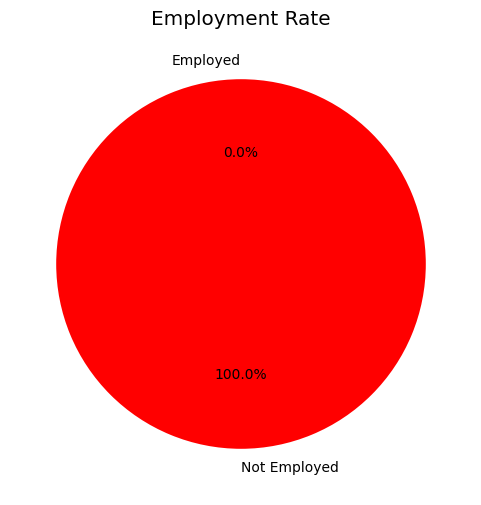

In [ ]:
#employed vs. not employed
employed = lfs_data[(lfs_data["PUFC11_WORK"] == 1) | (lfs_data["PUFC12_JOB"] == 1)].shape[0]
not_employed = lfs_data.shape[0] - employed

employment_counts = [employed, not_employed]
labels = ["Employed", "Not Employed"]

plt.figure(figsize=(6, 6))
plt.pie(employment_counts, labels=labels, autopct="%1.1f%%", colors=["green", "red"], startangle=90)
plt.title("Employment Rate")
plt.show()


4. What is the unemployment rate (PUFC30_LOOKW, PUFC36_AVAIL)?

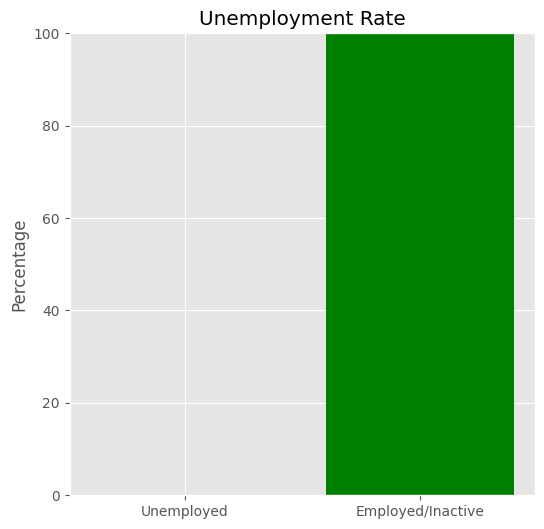

In [ ]:
#unemployed
unemployed = lfs_data[(lfs_data["PUFC30_LOOKW"] == 1) & (lfs_data["PUFC36_AVAIL"] == 1)].shape[0]
unemployment_rate = (unemployed / lfs_data.shape[0]) * 100  # Convert to percentage

plt.figure(figsize=(6, 6))
plt.bar(["Unemployed", "Employed/Inactive"], [unemployment_rate, 100 - unemployment_rate], color=["red", "green"])
plt.ylabel("Percentage")
plt.title("Unemployment Rate")
plt.ylim(0, 100)
plt.show()


5. What is the rate of underemployment (PUFC20_PWMORE, PUFC21_PLADDW)?

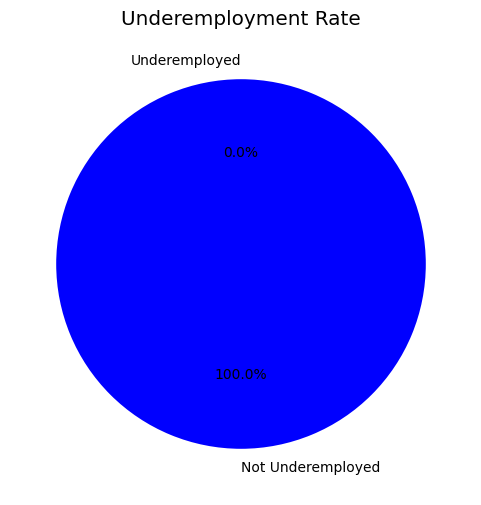

In [ ]:
#underemployed
underemployed = lfs_data[(lfs_data["PUFC20_PWMORE"] == 1) | (lfs_data["PUFC21_PLADDW"] == 1)].shape[0]
not_underemployed = lfs_data.shape[0] - underemployed

underemployment_counts = [underemployed, not_underemployed]
labels = ["Underemployed", "Not Underemployed"]

plt.figure(figsize=(6, 6))
plt.pie(underemployment_counts, labels=labels, autopct="%1.1f%%", colors=["orange", "blue"], startangle=90)
plt.title("Underemployment Rate")
plt.show()


<h1>Data Preprocessing and Data Cleaning</h1>

Replace all instances of one or more spaces with NaN

In [ ]:
lfs_data.replace(r"^\s+$", np.nan, regex=True, inplace=True)

NameError: name 'lfs_data' is not defined

<h2>PUFC06_MSTAT</h2>
Predictors:
<ul><li>PUFC05_AGE</li>
<li>PUFC04_SEX </li>
<li>PUFC03_REL </li></ul>

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

columns = ["PUFC06_MSTAT", "PUFC05_AGE", "PUFC04_SEX", "PUFC03_REL"]
lfs_data_PUFC06_MSTAT = lfs_data[columns]
pd.get_dummies(lfs_data_PUFC06_MSTAT, columns=["PUFC04_SEX", "PUFC03_REL"])

imputer = IterativeImputer(random_state=42)
# lfs_data_PUFC06_MSTAT = pd.DataFrame(imputer.fit_transform(lfs_data_PUFC06_MSTAT), columns=lfs_data_PUFC06_MSTAT.columns)
# lfs_data_PUFC06_MSTAT["PUFC06_MSTAT"].round().astype(int)



In [ ]:
lfs_data_PUFC06_MSTAT = pd.DataFrame(imputer.fit_transform(lfs_data_PUFC06_MSTAT), columns=lfs_data_PUFC06_MSTAT.columns)

ValueError: could not convert string to float: ' '

In [ ]:
lfs_data_PUFC06_MSTAT["PUFC06_MSTAT"].round().astype(int)

<h2>PUFC08_CURSCH</h2>
Is the person currently attending school?

TODO: 
since current variables are just 1 and 2<br>
where 1 or 2 represent "elementary education" and "secondary and tertiary education" accomplishment<br>
<br>
and so we will replace all null values with 0<br>
to represent having NOT finished elementary, secondary, or tertiary.<br>

PUFC31_FLWRK

PUFC32_JOBSM

PUFC33_WEEKS

PUFC35_LTLOOKW

PUFC36_AVAIL

PUFC37_WILLING

<h2>One Hot Encoding</h2>

In [ ]:
# idk pa what columns to hot encoding 
# df = pd.get_dummies(df, drop_first=True)  # One-hot encoding

<h2>Feature Selection</h2>

In [ ]:
# idk pa rin what to do here

Binary 

TODO:<br>
convert the columns that can be classified in a binary manner to 1s and 0s<br>
ie. employment status: instead of "employed" and "unemployed"<br>
convert to 1 and 0<br>

<h1>kNN</h1>

Employability or Job Prediction (kNN) (??)

Rural vs Urban Workforce Disparities (kNN)
<ul><li>group up regions that have similar labor market characteristics, challenges, and/or opportunities</li></ul>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# 1. Import the CSV file using pandas
try:
    lfs_data = pd.read_csv("LFS_PUF_April_2016.CSV")  # Replace with the actual file name/path
except FileNotFoundError:
    print("Error: CSV file not found. Please make sure the file exists in the correct directory or provide the correct path.")
    # Handle the error gracefully, e.g., exit the program or prompt the user for the correct path.
    exit()  # Or another appropriate error handling

# 2. Data Cleaning and Preprocessing (Crucial for kNN)

# --- A. Handle Missing Values ---
# kNN is sensitive to missing values.  You'll need to decide how to handle them.  Common options:

# Option 1: Drop rows with any missing values (if the number of missing values is small)
lfs_data.dropna(inplace=True)  # This modifies the DataFrame in place

# Option 2: Impute missing values (more common and often better)
#   - Numerical features: Use mean, median, or more advanced imputation (e.g., KNN imputation)
#     Example using median:
#     for col in lfs_data.select_dtypes(include=['number']).columns:
#         lfs_data[col].fillna(lfs_data[col].median(), inplace=True)

#   - Categorical features: Use mode (most frequent value)
#     for col in lfs_data.select_dtypes(exclude=['number']).columns:
#         lfs_data[col].fillna(lfs_data[col].mode()[0], inplace=True) # mode() returns a series, take the first element


# --- B. Feature Selection/Engineering ---
# Identify your target variable (the one you want to predict) and features (the ones you'll use for prediction).
# Example (replace 'TARGET_COLUMN' and 'FEATURE_COLUMNS' with your actual column names):
TARGET_COLUMN = 'EmploymentStatus' # Example - replace with your actual target variable
FEATURE_COLUMNS = ['Age', 'EducationLevel', 'Occupation'] # Example - replace with your feature columns

y = lfs_data[TARGET_COLUMN]  # Target variable
X = lfs_data[FEATURE_COLUMNS] # Features

# --- C. Encode Categorical Features ---
# kNN works with numerical data. Convert categorical features to numerical using one-hot encoding or label encoding.

X = pd.get_dummies(X) # One-hot encoding (often preferred for kNN)
# OR
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for col in X.select_dtypes(exclude=['number']).columns:
#     X[col] = le.fit_transform(X[col])

# --- D. Feature Scaling (Very Important for kNN) ---
# kNN is distance-based, so features with larger values can dominate. Scale your features.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Fit and transform the features

# 3. Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  # 80% train, 20% test

# 4. Train the kNN Classifier
k = 5  # Choose an appropriate value for k (number of neighbors) - often needs tuning
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# 5. Make Predictions
y_pred = knn.predict(X_test)

# 6. Evaluate the Model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


# --- Important Notes ---

# * **File Path:** Double-check the path to your CSV file.  If it's not in the same directory as your notebook, provide the full path.
# * **Data Exploration:** Before preprocessing, explore your data: `lfs_data.head()`, `lfs_data.info()`, `lfs_data.describe()`. This will help you understand the data types, missing values, and potential issues.
# * **Feature Engineering:**  The choice of features and how you engineer them is *crucial* for model performance.
# * **k Value Tuning:** Experiment with different values of `k` to find the optimal one. You can use techniques like cross-validation.
# * **Handling Imbalanced Datasets:** If your target variable has imbalanced classes (e.g., many more examples of one class than another), consider techniques like oversampling or undersampling.
# * **Computational Resources:** The LFS PUF is a large dataset. Be mindful of your computer's memory.  You might need to process the data in chunks if you run into memory issues.

Error: CSV file not found. Please make sure the file exists in the correct directory or provide the correct path.


NameError: name 'lfs_data' is not defined

: 

Logistic Regression

Employability (Binary Logistic Regression)

In [ ]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(
    loss='log_loss',
    eta0=0.001,
    max_iter=200,
    learning_rate='constant',
    random_state=1,
    verbose=1
)

<h1>try</h1>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data
try:
    lfs_data = pd.read_csv("LFS PUF April 2016.CSV")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: CSV file not found. Please ensure the file is in the correct directory or provide the correct path.")
    exit()

Data loaded successfully.


In [11]:
# 2. Data Cleaning and Preprocessing

# a. Handle Missing Values (Important!)
# Explore missing data:
print(lfs_data.isnull().sum()) # Check for missing values in each column
# Strategies for handling missing data (choose one or combine as appropriate):
# 1. Drop rows with many missing values (if applicable).
# 2. Impute missing numerical values (e.g., mean, median).
# 3. Impute missing categorical values (e.g., mode, or create a "missing" category).
# Example imputation (replace with more suitable strategy as needed):
# lfs_data['PUFC25_PBASIC'].fillna(lfs_data['PUFC25_PBASIC'].median(), inplace=True) # Impute with median for basic pay
# lfs_data['PUFC07_GRADE'].fillna("Unknown", inplace=True) # Impute with "Unknown" for grade

PUFREG             0
PUFPRV             0
PUFPRRCD           0
PUFHHNUM           0
PUFURB2K10         0
PUFPWGTFIN         0
PUFSVYMO           0
PUFSVYYR           0
PUFPSU             0
PUFRPL             0
PUFHHSIZE          0
PUFC01_LNO         0
PUFC03_REL         0
PUFC04_SEX         0
PUFC05_AGE         0
PUFC06_MSTAT       0
PUFC07_GRADE       0
PUFC08_CURSCH      0
PUFC09_GRADTECH    0
PUFC10_CONWR       0
PUFC11_WORK        0
PUFC12_JOB         0
PUFC14_PROCC       0
PUFC16_PKB         0
PUFC17_NATEM       0
PUFC18_PNWHRS      0
PUFC19_PHOURS      0
PUFC20_PWMORE      0
PUFC21_PLADDW      0
PUFC22_PFWRK       0
PUFC23_PCLASS      0
PUFC24_PBASIS      0
PUFC25_PBASIC      0
PUFC26_OJOB        0
PUFC27_NJOBS       0
PUFC28_THOURS      0
PUFC29_WWM48H      0
PUFC30_LOOKW       0
PUFC31_FLWRK       0
PUFC32_JOBSM       0
PUFC33_WEEKS       0
PUFC34_WYNOT       0
PUFC35_LTLOOKW     0
PUFC36_AVAIL       0
PUFC37_WILLING     0
PUFC38_PREVJOB     0
PUFC40_POCC        0
PUFC41_WQTR  

In [ ]:
# i think we can drop PUFSVYMO Survey month, PUFSVYYR Survey year

renamed_fucking_columns = {
    'PUFREG': 'Region',
    'PUFPRV' : 'Province code',
    'PUFPRRCD' : 'Province recode',
    'PUFHHNUM' : 'Household unique sequential number',
    'PUFURB2K10' : 'Urban / Rural',
    'PUFPWGTFIN' : 'Final weight',
    'PUFSVYMO' : 'Survey month',
    'PUFSVYYR' : 'Survey year',
    'PUFPSU' : 'PSU number',
    'PUFRPL' : 'Replicate',
    'PUFHHSIZE' : 'Number of household members',
    'PUFC01_LNO' : 'Line number used to identify each member of the household in the survey',
    'PUFC03_REL' : 'Relationship of the person to the household head',
    'PUFC04_SEX' : 'Sex of the person',
    'PUFC05_AGE' : 'Age of the person since last birthday',
    'PUFC06_MSTAT' : 'Marital status of the person since last birthday',
    'PUFC07_GRADE' : 'Highest grade completed of the person',
    'PUFC08_CURSCH' : 'Is the person currently attending school?',
    'PUFC09_GRADTECH' : 'Is the person a graduate of a technical / vocational course?',
    'PUFC10_CONWR' : 'Category of OFW',
    'PUFC11_WORK' : 'Did the person do any work for at least one house during the past week?',
    'PUFC12_JOB' : 'Although the person did not work last week, did the person have a job or business during the past week?',
    'PUFC14_PROCC' : 'What is the primary occupation of the person during the past week?',
    'PUFC16_PKB' : 'Kind of business or industry of the person',
    'PUFC17_NATEM' : 'Nature of employment of the person.',
        # This refers to the permanence or regularity or seasonality with which a particular work or job/business is being pursued.
    'PUFC18_PNWHRS' : 'Normal working hours per day',
        # Normal working hours worked per day is the usual or prescribed working hours of a person in his primary job/business, which is, considered a full day's work.
    'PUFC19_PHOURS' : 'Total number of hours worked during the past week',
        # The actual number of hours worked by a person in his primary job that he held during the past week or in his other job(s)/business if there are or if there is any.
        # It includes the duration or the period the person was occupied in his work, including overtime, but excluding hours paid but not worked. 
        # For wage and salary earners, it includes time worked without compensation in connection with their occupations, 
        # such as the time a teacher spends at home preparing for the forthcoming lectures. 
        # For own account workers, it includes the time spent in the shop, business or office, even if no sale or transaction has taken place.
    'PUFC20_PWMORE' : 'Do you want more hours of work during the past week?',
    'PUFC21_PLADDW' : 'Did the person look for additional work during the past week?',
    'PUFC22_PFWRK' : "Was this the person's first time to do any work?",
        # This question determines whether a person is a “new entrant” to the labor force. 
        # A person is a new entrant if it is his first time to do any work.
        # A person is considered to have worked only for the first time if he started working only during the current survey period.
        # Current survey period refers to April 1 - 30 for this survey round
    'PUFC23_PCLASS' : 'Class of worker for primary occupation',
        # Class of worker is the relationship of the worker to the establishment where he works.
    'PUFC24_PBASIS' : 'Basis of payment for primary occupation',
    'PUFC25_PBASIC' : 'Basic pay per day for primary occupation',
        # Basic pay is the pay for normal time, prior to deductions of social security contributions, withholding taxes, etc. 
        # It excludes allowances, bonuses, commissions, overtime pay, benefits in kind, etc. 
        # This is also called basic wage.
    'PUFC26_OJOB' : 'Did the person have other job or business during the past week?',
    'PUFC27_NJOBS' : 'Number of jobs the person had during the past week',
    'PUFC28_THOURS' : 'Total number of hours worked by the person for all his jobs during the past week',
    'PUFC29_WWM48H' : 'Main reason for not working more than 48 hours in the past week',
    'PUFC30_LOOKW' : 'Did the person look for work or try to establish a business in the past week?',
    'PUFC31_FLWRK' : "Was it the person's first time looking for work or trying to establish a business?",
    'PUFC32_JOBSM' : 'Job search method',
        # What has the person been doing to find work?
    'PUFC33_WEEKS' : 'Number of weeks spent in looking for work',
        # How many weeks has the person been looking for work?',
    'PUFC34_WYNOT' : 'Reason for not looking for work Why did the person not look for work?',
    'PUFC35_LTLOOKW' : 'When was the last time the person looked for work?',
    'PUFC36_AVAIL' : 'Had opportunity for work existed last week or within two weeks, would the person have been available?',
    'PUFC37_WILLING' : 'Is the person willing to take up work in the past week or within 2 weeks?',
    'PUFC38_PREVJOB' : 'Has the person worked at any time before?',
    'PUFC40_POCC' : 'What was the person’s last occupation?',
    'PUFC41_WQTR' : 'Did the person work at all or had a job or business during the past quarter?',
    'PUFC43_QKB' : 'Kind of business for the past quarter',
    'PUFNEWEMPSTAT' : 'New Employment Criteria'
}
pd.set_option('display.max_columns', None)
lfs_data.rename(columns=renamed_fucking_columns, inplace=True)

lfs_data.head(50)

NameError: name 'pd' is not defined

In [ ]:
# b. Feature Selection (Crucial for a good model)
# Identify features relevant to employability.  Consider these factors:
# * Demographic features (age, sex, marital status, education)
# * Work experience (previous jobs, hours worked)
# * Job search activity (looking for work, methods used)
# * Availability and willingness to work
# * Location (region, urban/rural)

# Example: Select some potentially relevant features (you'll likely want to refine this):
selected_features = ['PUFC05_AGE', 'PUFC04_SEX', 'PUFC07_GRADE', 'PUFC11_WORK', 'PUFC14_PROCC', 'PUFC17_NATEM', 'PUFC23_PCLASS', 'PUFC30_LOOKW', 'PUFC36_AVAIL', 'PUFC37_WILLING', 'PUFNEWEMPSTAT']  # Add more!
lfs_data = lfs_data[selected_features]

# c. Encode Categorical Variables
# Logistic regression works with numerical data. Convert categorical features:
lfs_data = pd.get_dummies(lfs_data, columns=['PUFC04_SEX', 'PUFC07_GRADE', 'PUFC11_WORK', 'PUFC14_PROCC', 'PUFC17_NATEM', 'PUFC23_PCLASS', 'PUFC30_LOOKW', 'PUFC36_AVAIL', 'PUFC37_WILLING']) # One-hot encoding

# d. Define Target Variable (Employability)
# You'll need to define what "employable" means in your context.
# Example: If PUFNEWEMPSTAT indicates employment status, you might use it directly.
# Or, you might create a new target variable based on a combination of factors.
# Example (using PUFNEWEMPSTAT directly as a binary indicator - Adapt as needed):
lfs_data['employable'] = lfs_data['PUFNEWEMPSTAT'].apply(lambda x: 1 if x in [1, 2, 3] else 0) # Example: 1 if employed, 0 if not.  Adjust based on your data.
lfs_data.drop('PUFNEWEMPSTAT', axis=1, inplace=True) # Remove the original employment status column if you created a new 'employable' column


In [ ]:

# 3. Model Training
X = lfs_data.drop('employable', axis=1)  # Features
y = lfs_data['employable']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data

model = LogisticRegression(max_iter=1000) # Increase max_iter if needed.
model.fit(X_train, y_train)



KeyError: "['employable'] not found in axis"

In [ ]:
# 4. Model Evaluation
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


NameError: name 'model' is not defined

In [ ]:
# 5. Feature Importance (Optional but helpful)
# Logistic regression can provide some insight into feature importance (coefficients):
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


# Suggestions for an Outstanding Model:

# * Thorough Data Cleaning: Handle missing values strategically.  Don't just drop them blindly. Imputation is often better.
# * Feature Engineering: Create new features from existing ones.  For example, combine education and work experience.
# * Feature Selection: Carefully choose the most relevant features. Use domain knowledge, statistical tests, or feature selection techniques (e.g., recursive feature elimination).
# * Model Selection: Don't be limited to logistic regression. Explore other models like Random Forest, Gradient Boosting, or Support Vector Machines.
# * Hyperparameter Tuning: Optimize the model's parameters using techniques like GridSearchCV or RandomizedSearchCV.
# * Cross-Validation: Use techniques like k-fold cross-validation to get a more robust estimate of model performance.
# * Address Class Imbalance (if present): If your dataset has a significantly unequal number of "employable" and "not employable" individuals, consider techniques like oversampling or undersampling.
# * Domain Expertise:  The most important thing! Work with people who understand the Philippine labor market. Their insights will be invaluable for feature selection, defining "employability," and interpreting the model's results.
# * Explainability: Consider using techniques to make your model more interpretable. This is important for understanding why the model is making certain predictions.